# Usage notebook

This notebook will analyse the general usage of the assistant in the participating courses

In [1]:
from helper_functions import save_plot, save_variable, save_table
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from getpass import getpass
import seaborn as sns
import pandas as pd

## Configuration

In [2]:
# Exclude ID 1: DD2445 Complexity Theory 7.5 credits
# Exclude ID 6: DA231X Degree Project in Computer Science and Engineering, Second Cycle 30.0 credits
# These were just used for testing, not actually included in the study
exclude_courses = [1, 6]

## Load the data from the database

In [3]:
# Configure the database
DB_TYPE = 'postgresql'
DB_DRIVER = 'psycopg2'
DB_USER = 'postgres'
DB_PASS = getpass('Enter your database password: ')
DB_HOST = 'localhost'
DB_PORT = '5432'
DB_NAME = 'kthassistant_local'

DATABASE_URL = f'{DB_TYPE}+{DB_DRIVER}://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}'
engine = create_engine(DATABASE_URL)

In [4]:
# Load all data, re-run this to refresh
tables = [
    'chat_configs',
    'chats',
    'content',
    'cookies',
    'courses',
    'faq_snapshots',
    'faqs',
    'feedback',
    'feedback_questions',
    'messages',
    'migratehistory',
    'prompt_handles',
    'sessions',
    'snapshots',
    'urls'
]

dataframes = {}
for table in tqdm(tables):
    dataframes[table] = pd.read_sql_table(table, engine)

  0%|          | 0/15 [00:00<?, ?it/s]

In [5]:
# Print the structure
for table, df in dataframes.items():
    print(f"Structure of DataFrame for table `{table}`")
    print(df.info())
    print("\n")

Structure of DataFrame for table `chat_configs`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              15 non-null     int64         
 1   created_at      15 non-null     datetime64[ns]
 2   modified_at     15 non-null     datetime64[ns]
 3   is_active       15 non-null     bool          
 4   llm_model_name  15 non-null     object        
 5   index_type      15 non-null     object        
dtypes: bool(1), datetime64[ns](2), int64(1), object(2)
memory usage: 747.0+ bytes
None


Structure of DataFrame for table `chats`
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5981 entries, 0 to 5980
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                5981 non-null   int64         
 1   created_at        5981 non-nu

## Number of chats per day (cummulative)

Saved latex variable to usage-01-total-number-of-chats
Saved plot to usage-01-cumulative-number-of-chats


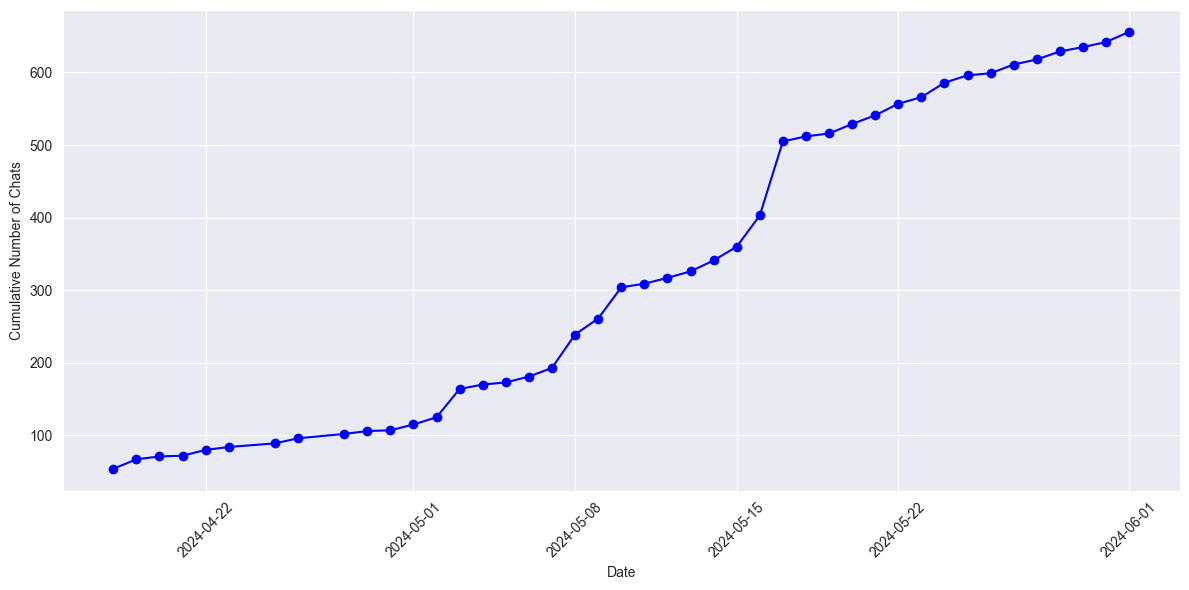

In [6]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

df_filtered = df_filtered[~df_filtered['course_id'].isin(exclude_courses)]

df_filtered = df_filtered[pd.to_datetime(df_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

chats_per_day_filtered = df_filtered.groupby(df_filtered['created_at'].dt.date).size()
chats_per_day_cumulative = chats_per_day_filtered.cumsum()

save_variable("usage-01-total-number-of-chats", str(chats_per_day_cumulative.iloc[-1]))

plt.figure(figsize=(12, 6))
plt.plot(chats_per_day_cumulative.index, chats_per_day_cumulative.values, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Chats')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt, "usage-01-cumulative-number-of-chats", "Cumulative number of chats started by users participating in the study", "fig:usage_01_cumulative_number_of_chats")
plt.show()

Saved plot to usage-02-cumulative-number-of-chats-per-course


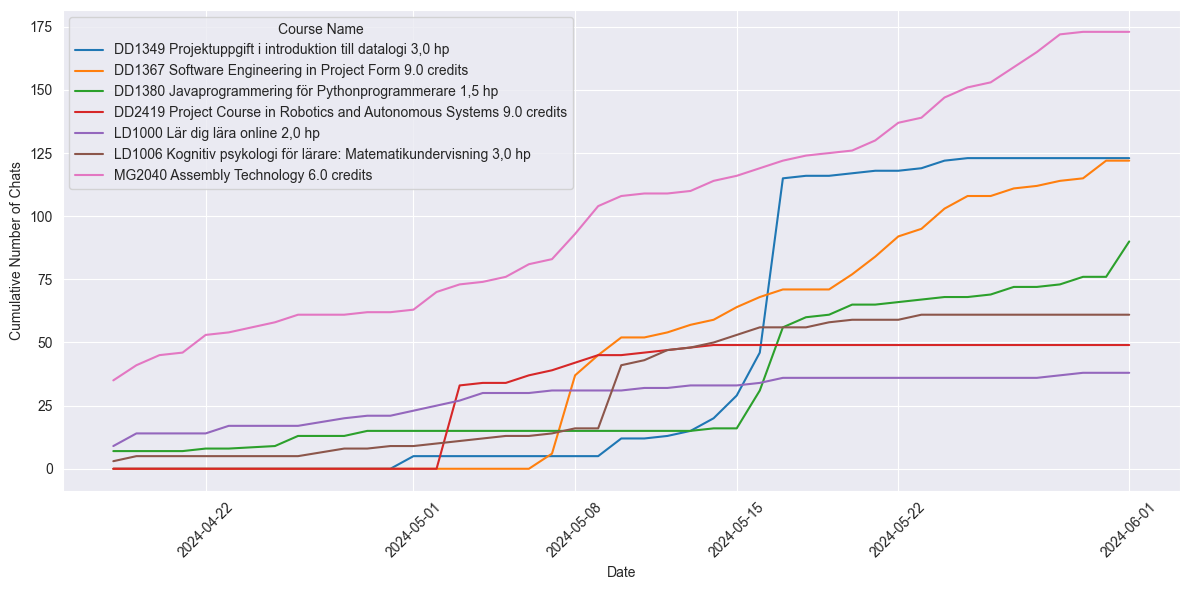

In [7]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left', suffixes=('', '_session'))

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()
df_filtered = df_filtered[pd.to_datetime(df_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

df_filtered_with_names = df_filtered_with_names[~df_filtered_with_names['course_id'].isin(exclude_courses)]

chats_per_day_per_course_name = df_filtered_with_names.groupby(['name', df_filtered_with_names['created_at'].dt.date]).size().unstack(fill_value=0)

cumulative_chats_per_course_name = chats_per_day_per_course_name.cumsum(axis=1).T

plt.figure(figsize=(12, 6))
for course_name in cumulative_chats_per_course_name.columns:
    plt.plot(cumulative_chats_per_course_name.index, cumulative_chats_per_course_name[course_name], linestyle='-', label=course_name)

plt.xlabel('Date')
plt.ylabel('Cumulative Number of Chats')
plt.legend(title='Course Name')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt, "usage-02-cumulative-number-of-chats-per-course", "Cumulative number of chats started by users participating in the study in each course", "fig:usage_02_cumulative_number_of_chats_per_course")
plt.show()

## Chats per week

Saved plot to usage-03-number-of-chats-per-calendar-week


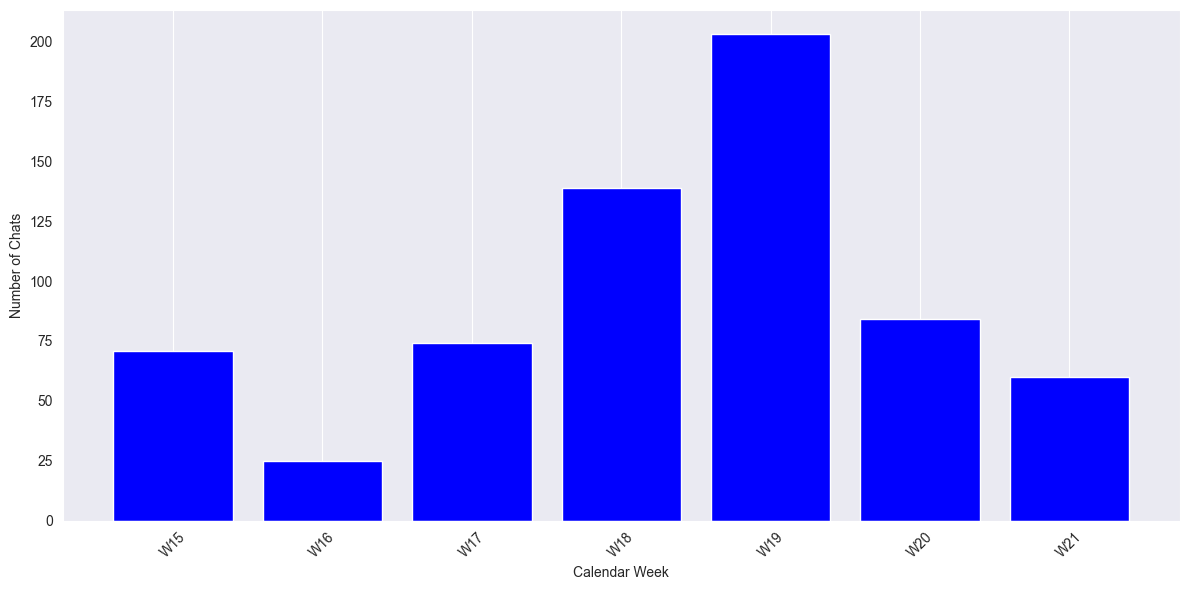

In [8]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()
df_filtered = df_filtered[pd.to_datetime(df_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

df_filtered = df_filtered[~df_filtered['course_id'].isin(exclude_courses)]

df_filtered['week'] = df_filtered['created_at'].dt.strftime('W%U')

chats_per_week_calendar = df_filtered.groupby('week').size()

plt.figure(figsize=(12, 6))
plt.bar(chats_per_week_calendar.index, chats_per_week_calendar.values, color='b')
plt.xlabel('Calendar Week')
plt.ylabel('Number of Chats')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt, "usage-03-number-of-chats-per-calendar-week", "Number of chats held each week", "fig:usage_03_number_of_chats_per_calendar_week")
plt.show()

Saved plot to usage-04-number-of-chats-per-calendar-week-per-course


<Figure size 1200x600 with 0 Axes>

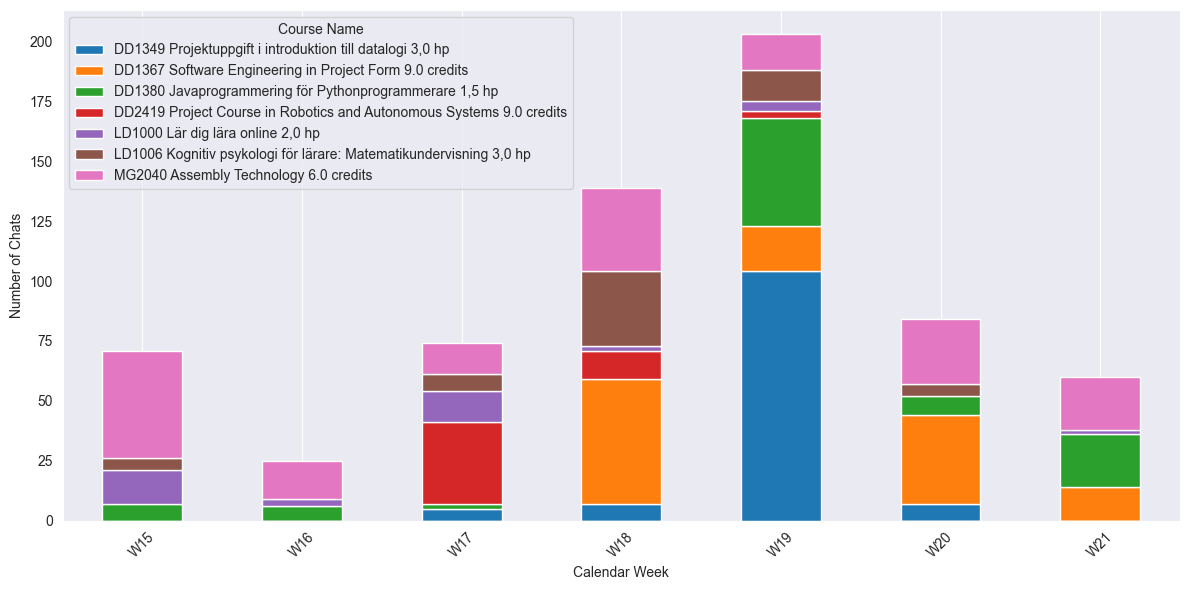

In [9]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()
df_filtered = df_filtered[pd.to_datetime(df_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

df_filtered = df_filtered[~df_filtered['course_id'].isin(exclude_courses)]

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

df_filtered_with_names['week'] = df_filtered_with_names['created_at'].dt.strftime('W%U')
chats_per_week_per_course = df_filtered_with_names.groupby(['name', 'week']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
chats_per_week_per_course.T.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.xlabel('Calendar Week')
plt.ylabel('Number of Chats')
plt.legend(title='Course Name')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt, "usage-04-number-of-chats-per-calendar-week-per-course", "Number of chats held each week per course", "fig:usage_03_number_of_chats_per_calendar_week_per_course")
plt.show()

Saved latex variable to usage-04-chats-mg2040
Saved latex variable to usage-05-chats-dd1349
Saved latex variable to usage-06-chats-dd1367
Saved plot to usage-05-number-of-chats-per-course


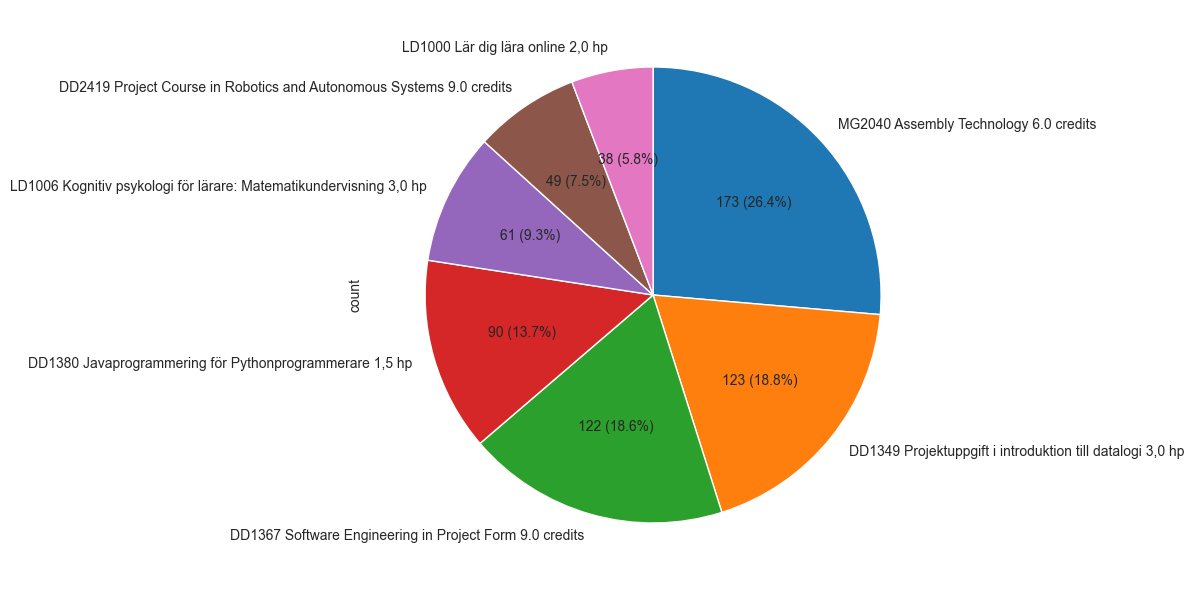

In [10]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()
df_filtered = df_filtered[pd.to_datetime(df_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

df_filtered = df_filtered[~df_filtered['course_id'].isin(exclude_courses)]

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

total_chats_per_course = df_filtered_with_names['name'].value_counts()

plt.figure(figsize=(12, 6))
total_chats_per_course.plot(kind='pie', autopct=lambda p: '{:.0f} ({:.1f}%)'.format(p * total_chats_per_course.sum() / 100, p), startangle=90, counterclock=False)

save_variable("usage-04-chats-mg2040", str(total_chats_per_course['MG2040 Assembly Technology 6.0 credits']))
save_variable("usage-05-chats-dd1349", str(total_chats_per_course['DD1349 Projektuppgift i introduktion till datalogi 3,0 hp']))
save_variable("usage-06-chats-dd1367", str(total_chats_per_course['DD1367 Software Engineering in Project Form 9.0 credits']))

plt.tight_layout()
save_plot(plt, "usage-05-number-of-chats-per-course", "Number of chats held by in each course", "fig:usage_03_number_of_chats_per_course")
plt.show()

## Number of sessions (number of users)

Saved plot to usage-06-number-of-sessions-per-day


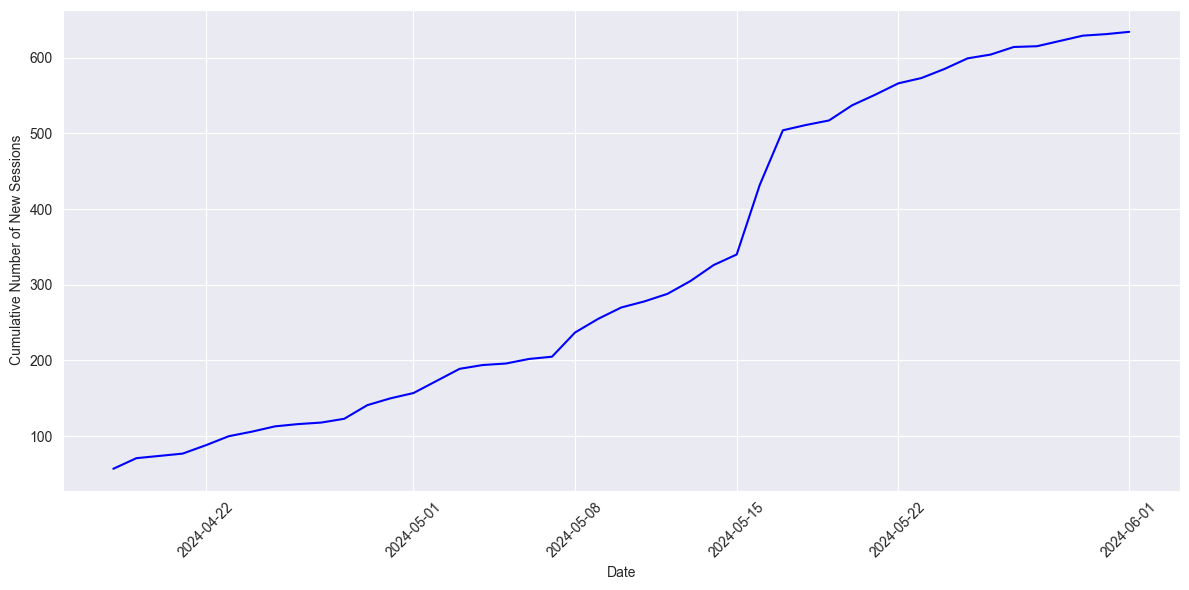

In [11]:
df_sessions = dataframes['sessions']

df_sessions['created_at'] = pd.to_datetime(df_sessions['created_at'])

df_sessions_filtered = df_sessions[df_sessions['is_test_user'] == False].copy()
df_sessions_filtered = df_sessions_filtered[pd.to_datetime(df_sessions_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

sessions_per_day = df_sessions_filtered.groupby(df_sessions_filtered['created_at'].dt.date).size()

cumulative_sessions_per_day = sessions_per_day.cumsum()

plt.figure(figsize=(12, 6))
plt.plot(cumulative_sessions_per_day.index, cumulative_sessions_per_day.values, marker='', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of New Sessions')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt, "usage-06-number-of-sessions-per-day", "Cumulative number of sessions per day", "fig:usage_06_number_of_sessions_per_day")
plt.show()

Saved plot to usage-07-number-of-sessions-per-day-and-course


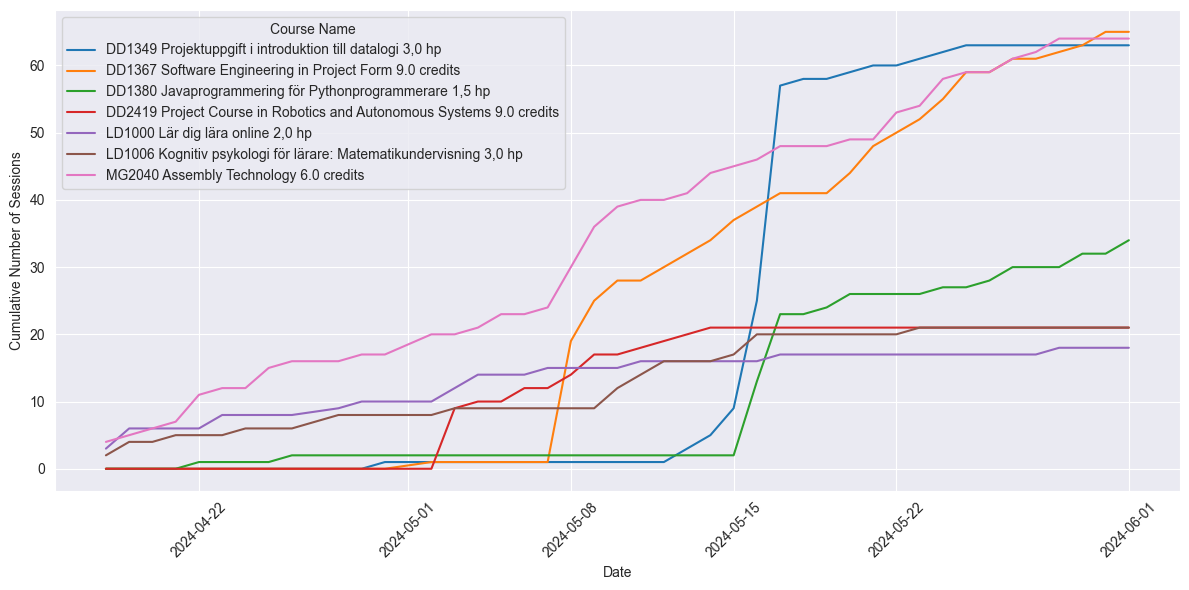

In [12]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_courses = dataframes['courses']

df_sessions['created_at'] = pd.to_datetime(df_sessions['created_at'])
df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user', 'created_at']], left_on='session_id', right_on='id', how='left')

df_filtered = df_merged[df_merged['is_test_user'] == False].copy()
df_filtered = df_filtered[pd.to_datetime(df_filtered['created_at_y']).dt.date >= pd.to_datetime('2024-04-18').date()]

df_filtered = df_filtered[~df_filtered['course_id'].isin(exclude_courses)]

df_filtered_with_names = pd.merge(df_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

sessions_per_day_per_course = df_filtered_with_names.groupby(['name', df_filtered_with_names['created_at_y'].dt.date])['session_id'].nunique().unstack(fill_value=0)

cumulative_sessions_per_course = sessions_per_day_per_course.cumsum(axis=1).T

plt.figure(figsize=(12, 6))
for course_name in cumulative_sessions_per_course.columns:
    plt.plot(cumulative_sessions_per_course.index, cumulative_sessions_per_course[course_name], marker='', linestyle='-', label=course_name)

plt.xlabel('Date')
plt.ylabel('Cumulative Number of Sessions')
plt.legend(title='Course Name')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt, "usage-07-number-of-sessions-per-day-and-course", "Cumulative number of sessions per day in each course", "fig:usage_07_number_of_sessions_per_day_and_course")
plt.show()

## Number of messages

Saved latex variable to usage-07-total-number-of-messages
Saved plot to usage-08-number-of-messages-per-day


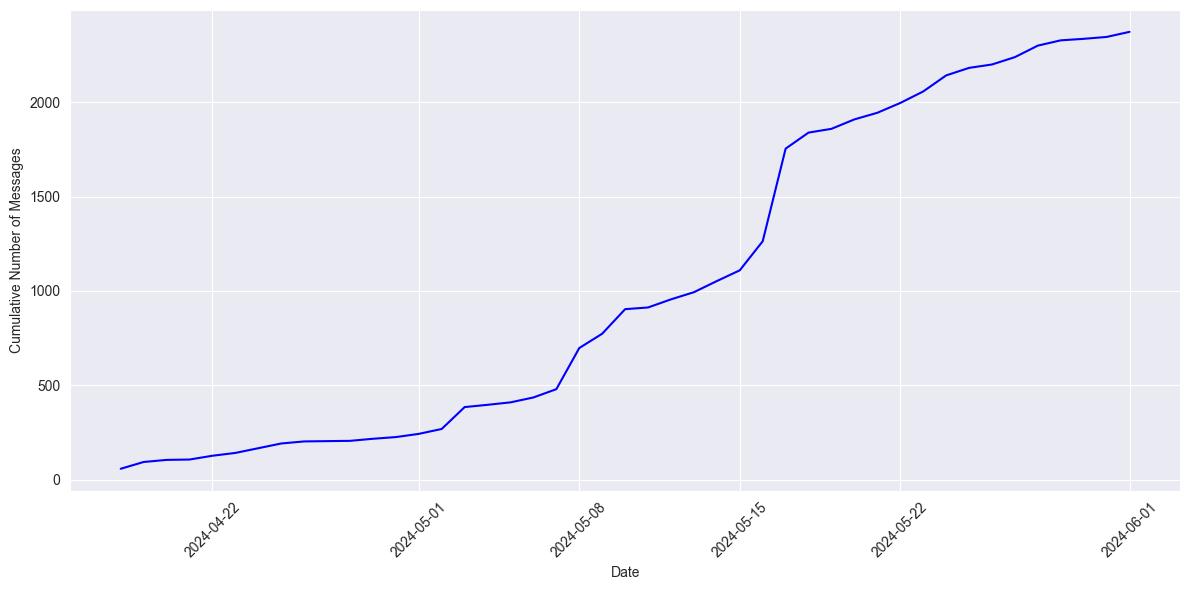

In [13]:
df_chats = dataframes['chats']
df_messages = dataframes['messages']
df_sessions = dataframes['sessions']

df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])
df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_messages_filtered = pd.merge(df_messages, df_chats[['id', 'course_id', 'session_id']], left_on='chat_id', right_on='id', how='left')

df_messages_filtered = pd.merge(df_messages_filtered, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_messages_filtered = df_messages_filtered[df_messages_filtered['is_test_user'] == False]
df_messages_filtered = df_messages_filtered[pd.to_datetime(df_messages_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

df_messages_filtered = df_messages_filtered[~df_messages_filtered['course_id'].isin(exclude_courses)]

messages_per_day = df_messages_filtered.groupby(df_messages_filtered['created_at'].dt.date).size()
cumulative_messages_per_day = messages_per_day.cumsum()

save_variable("usage-07-total-number-of-messages", str(cumulative_messages_per_day.iloc[-1]))

plt.figure(figsize=(12, 6))
plt.plot(cumulative_messages_per_day.index, cumulative_messages_per_day.values, marker='', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Cumulative Number of Messages')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt, "usage-08-number-of-messages-per-day", "Cumulative number of messages per day", "fig:usage_08_number_of_messages_per_day")
plt.show()

Saved plot to usage-09-number-of-messages-per-day-and-course


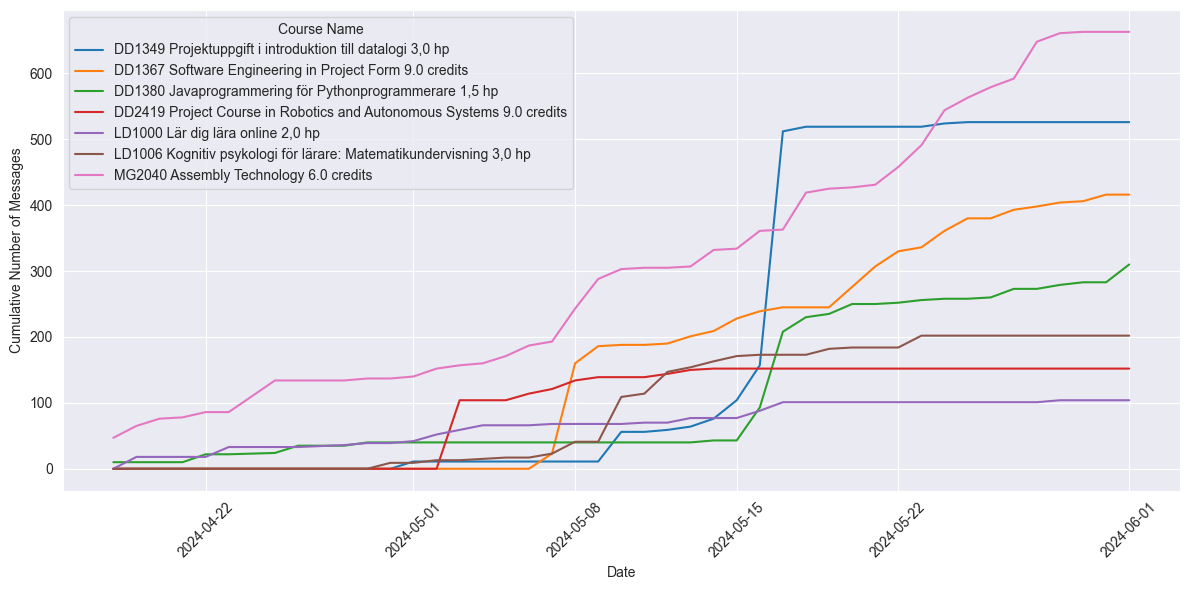

In [14]:
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])
df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_messages_filtered = pd.merge(df_messages, df_chats[['id', 'course_id', 'session_id']], left_on='chat_id', right_on='id', how='left')

df_messages_filtered = pd.merge(df_messages_filtered, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_messages_filtered = df_messages_filtered[df_messages_filtered['is_test_user'] == False]
df_messages_filtered = df_messages_filtered[pd.to_datetime(df_messages_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

df_messages_filtered = df_messages_filtered[~df_messages_filtered['course_id'].isin(exclude_courses)]

df_messages_with_names = pd.merge(df_messages_filtered, df_courses, left_on='course_id', right_on='id', how='left', suffixes=('', '_course'))

messages_per_day_per_course = df_messages_with_names.groupby(['name', df_messages_with_names['created_at'].dt.date]).size().unstack(fill_value=0)

cumulative_messages_per_course = messages_per_day_per_course.cumsum(axis=1).T

plt.figure(figsize=(12, 6))
for course_name in cumulative_messages_per_course.columns:
    plt.plot(cumulative_messages_per_course.index, cumulative_messages_per_course[course_name], marker='', linestyle='-', label=course_name)

plt.xlabel('Date')
plt.ylabel('Cumulative Number of Messages')
plt.legend(title='Course Name')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt, "usage-09-number-of-messages-per-day-and-course", "Cumulative number of messages per day in each course", "fig:usage_09_number_of_messages_per_day_and_course")
plt.show()

## Unique users

Saved plot to usage-10-number-of-unique-sessions


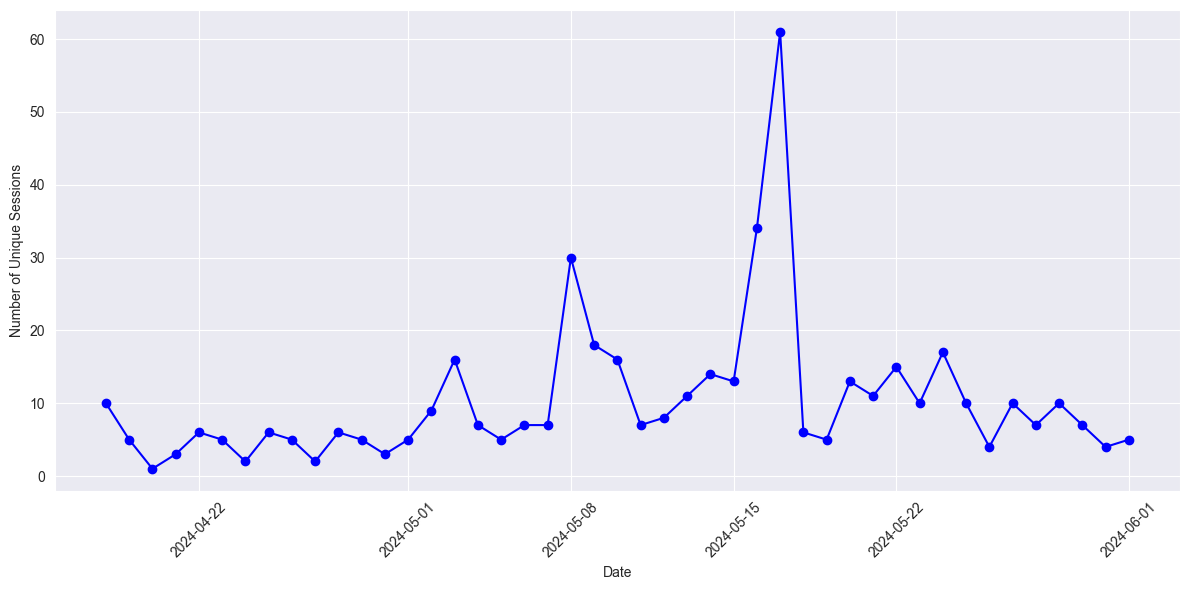

In [15]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])
df_sessions['created_at'] = pd.to_datetime(df_sessions['created_at'])

df_chats_filtered = df_chats[~df_chats['course_id'].isin(exclude_courses)]
df_chats_filtered = df_chats_filtered[pd.to_datetime(df_chats_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

unique_sessions_per_day = df_chats_filtered.groupby(df_chats_filtered['created_at'].dt.date)['session_id'].nunique()

plt.figure(figsize=(12, 6))
plt.plot(unique_sessions_per_day.index, unique_sessions_per_day.values, marker='o', linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Number of Unique Sessions')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt, "usage-10-number-of-unique-sessions", "Number of new unique sessions started each day", "fig:usage_10_number_of_unique_sessions")
plt.show()

Saved plot to usage-11-number-of-unique-sessions-with-one-chat


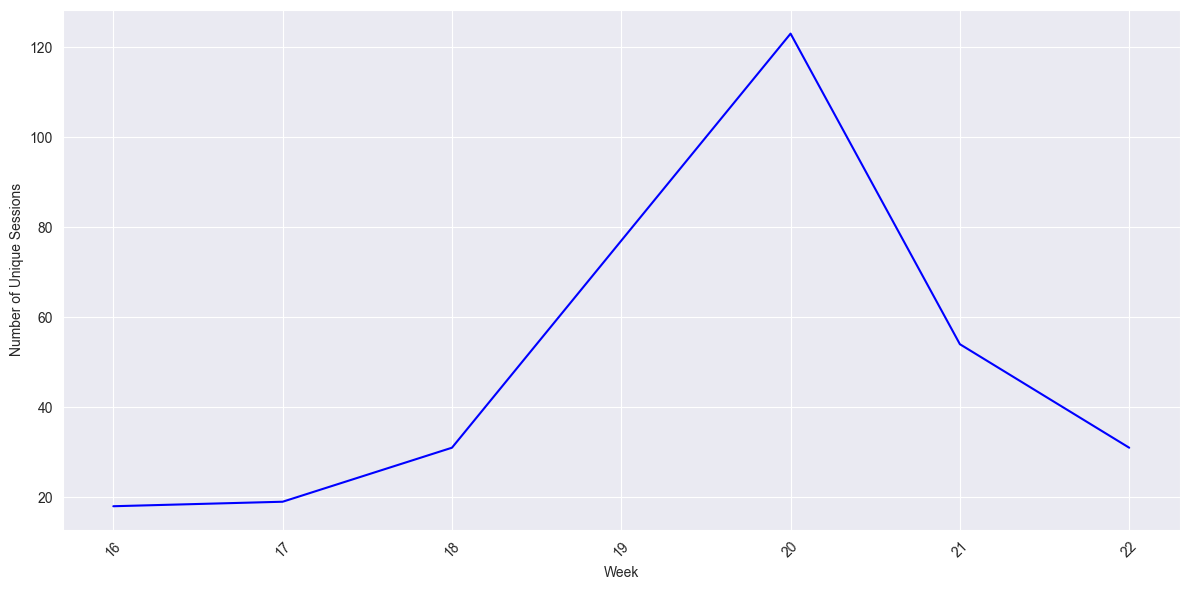

In [16]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])
df_sessions['created_at'] = pd.to_datetime(df_sessions['created_at'])

df_chats_filtered = df_chats[~df_chats['course_id'].isin(exclude_courses)]
df_chats_filtered = df_chats_filtered[pd.to_datetime(df_chats_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

unique_sessions_per_week = df_chats_filtered.groupby(df_chats_filtered['created_at'].dt.isocalendar().week)['session_id'].nunique()

plt.figure(figsize=(12, 6))
plt.plot(unique_sessions_per_week.index.astype(str), unique_sessions_per_week.values, marker='', linestyle='-', color='b')
plt.xlabel('Week')
plt.ylabel('Number of Unique Sessions')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
save_plot(plt, "usage-11-number-of-unique-sessions-with-one-chat", "Number of unique sessions with at least one chat", "fig:usage_11_number_of_unique_sessions_with_one_chat")
plt.show()

Saved latex variable to usage-02-average-chats-per-session
Saved plot to usage-12-number-of-sessions-with-number-of-chats


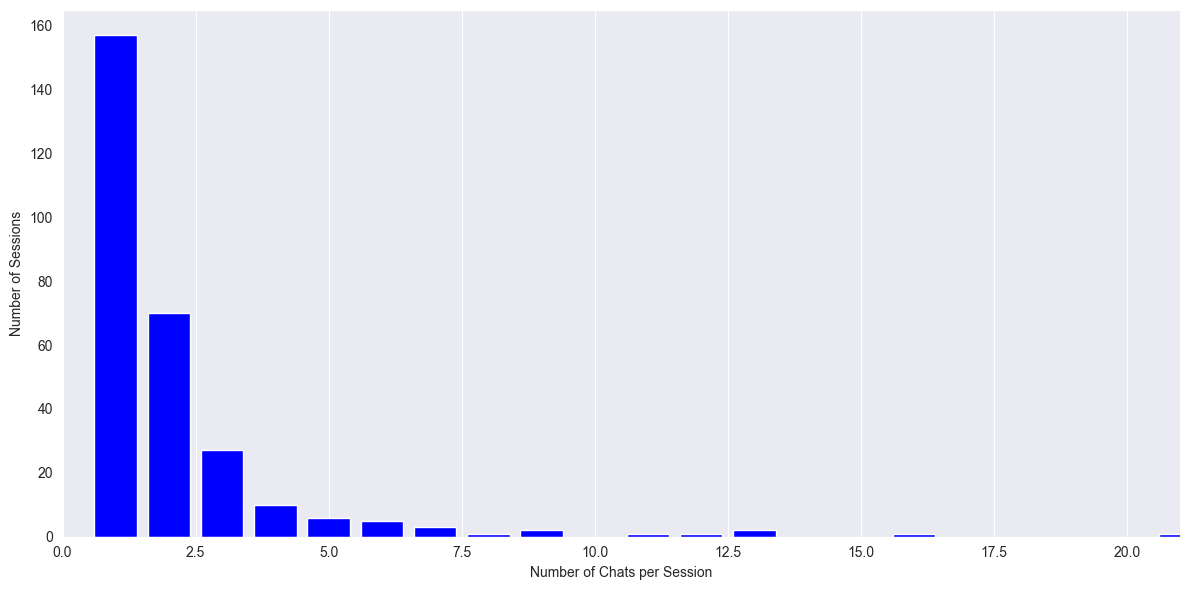

In [17]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])

df_chats_filtered = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_chats_filtered = df_chats_filtered[df_chats_filtered['is_test_user'] == False]
df_chats_filtered = df_chats_filtered[pd.to_datetime(df_chats_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

df_chats_filtered = df_chats_filtered[~df_chats_filtered['course_id'].isin(exclude_courses)]

chats_per_session = df_chats_filtered['session_id'].value_counts()

sessions_per_chat_count = chats_per_session.value_counts().sort_index()

limit = sessions_per_chat_count.index[-2]

average_chats_per_user = chats_per_session.mean()
save_variable("usage-02-average-chats-per-session", str(round(average_chats_per_user, 2)))

plt.figure(figsize=(12, 6))
plt.bar(sessions_per_chat_count.index, sessions_per_chat_count.values, color='b')
plt.xlabel('Number of Chats per Session')
plt.ylabel('Number of Sessions')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.xlim(0, limit)
plt.tight_layout()
save_plot(plt, "usage-12-number-of-sessions-with-number-of-chats", "Number of sessions with each number of chats", "fig:usage_12_number_of_sessions_with_number_of_chats")
plt.show()

Saved latex variable to usage-03-average-messages-per-session
Saved plot to usage-13-number-of-sessions-with-number-of-messages


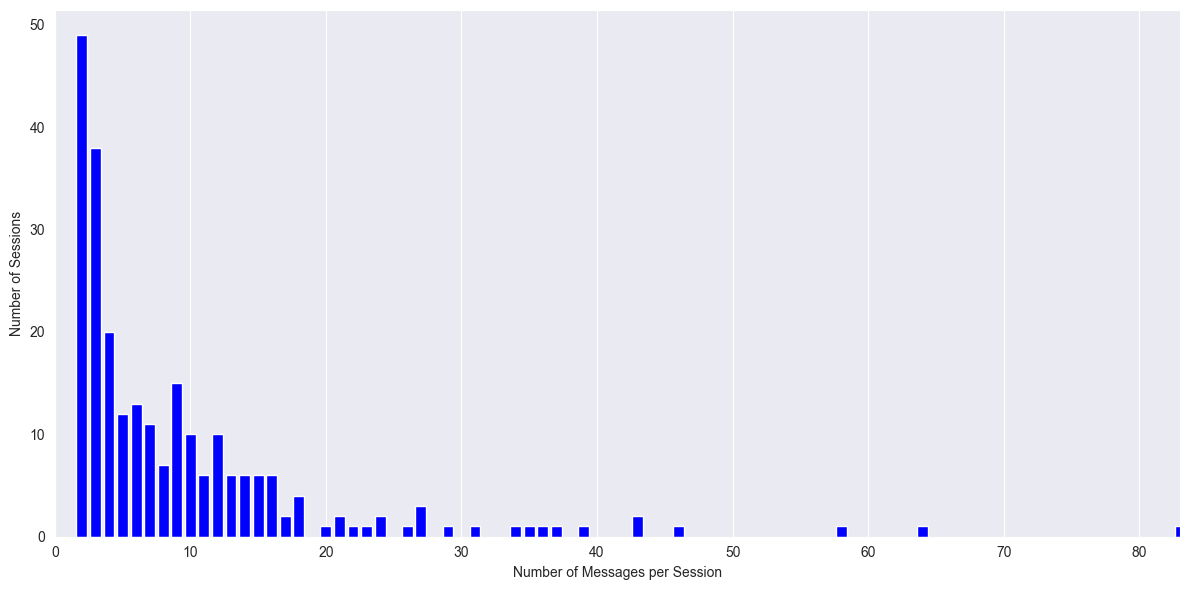

In [18]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_messages = dataframes['messages']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])

df_messages_filtered = pd.merge(df_messages, df_chats[['id', 'course_id', 'session_id']], left_on='chat_id', right_on='id', how='left')

df_messages_filtered = pd.merge(df_messages_filtered, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')

df_messages_filtered = df_messages_filtered[df_messages_filtered['is_test_user'] == False]
df_messages_filtered = df_messages_filtered[pd.to_datetime(df_messages_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]

df_messages_filtered = df_messages_filtered[~df_messages_filtered['course_id'].isin(exclude_courses)]

messages_per_session = df_messages_filtered['session_id'].value_counts()

sessions_per_message_count = messages_per_session.value_counts().sort_index()

average_messages_per_user = messages_per_session.mean()
save_variable("usage-03-average-messages-per-session", str(round(average_messages_per_user, 2)))

limit = sessions_per_message_count.index[-2]

plt.figure(figsize=(12, 6))
plt.bar(sessions_per_message_count.index, sessions_per_message_count.values, color='b')
plt.xlabel('Number of Messages per Session')
plt.ylabel('Number of Sessions')
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.xlim(0, limit)
plt.tight_layout()
save_plot(plt, "usage-13-number-of-sessions-with-number-of-messages", "Number of sessions with each number of messages", "fig:usage_13_number_of_sessions_with_number_of_messages")
plt.show()

## Usage by models

In [19]:
df_chats = dataframes['chats']
df_sessions = dataframes['sessions']
df_messages = dataframes['messages']

df_chats['created_at'] = pd.to_datetime(df_chats['created_at'])
df_messages['created_at'] = pd.to_datetime(df_messages['created_at'])
df_sessions['created_at'] = pd.to_datetime(df_sessions['created_at'])

models_to_include = ["openai/gpt4", "mistralai/Mistral-7B-Instruct-v0.2"]

df_merged = pd.merge(df_chats, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')
df_filtered = df_merged[df_merged['is_test_user'] == False].copy()

df_filtered = df_filtered[~df_filtered['course_id'].isin(exclude_courses)]
df_filtered = df_filtered[pd.to_datetime(df_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]
df_filtered = df_filtered[df_filtered['llm_model_name'].isin(models_to_include)]

chats_per_day_filtered = df_filtered.groupby(df_filtered['created_at'].dt.date).size()
chats_per_day_cumulative = chats_per_day_filtered.cumsum()

df_sessions_filtered = df_sessions[df_sessions['is_test_user'] == False].copy()
df_sessions_filtered = df_sessions_filtered[pd.to_datetime(df_sessions_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]
df_sessions_filtered = df_sessions_filtered[df_sessions_filtered['default_llm_model_name'].isin(models_to_include)]

sessions_per_day = df_sessions_filtered.groupby(df_sessions_filtered['created_at'].dt.date).size()
cumulative_sessions_per_day = sessions_per_day.cumsum()

df_messages_filtered = pd.merge(df_messages, df_chats[['id', 'course_id', 'session_id', 'llm_model_name']], left_on='chat_id', right_on='id', how='left')
df_messages_filtered = pd.merge(df_messages_filtered, df_sessions[['id', 'is_test_user']], left_on='session_id', right_on='id', how='left')
df_messages_filtered = df_messages_filtered[df_messages_filtered['is_test_user'] == False]
df_messages_filtered = df_messages_filtered[pd.to_datetime(df_messages_filtered['created_at']).dt.date >= pd.to_datetime('2024-04-18').date()]
df_messages_filtered = df_messages_filtered[~df_messages_filtered['course_id'].isin(exclude_courses)]
df_messages_filtered = df_messages_filtered[df_messages_filtered['llm_model_name'].isin(models_to_include)]

# compute the statistics
messages_per_day = df_messages_filtered.groupby(df_messages_filtered['created_at'].dt.date).size()
cumulative_messages_per_day = messages_per_day.cumsum()

session_model_counts = df_sessions_filtered['default_llm_model_name'].value_counts()
session_model_percentages = round((session_model_counts / session_model_counts.sum()) * 100, 2)

chat_model_counts = df_filtered['llm_model_name'].value_counts()
chat_model_percentages = round((chat_model_counts / chat_model_counts.sum()) * 100, 2)

message_model_counts = df_messages_filtered['llm_model_name'].value_counts()
message_model_percentages = round((message_model_counts / message_model_counts.sum()) * 100, 2)

session_stats = pd.DataFrame({
    'Model': session_model_counts.index,
    'Number of Sessions': session_model_counts.values,
    'Percentage of Sessions': session_model_percentages.values
})

merged_stats = session_stats.merge(chat_model_counts.rename('Number of Chats'), left_on='Model', right_index=True, how='left')
merged_stats = merged_stats.merge(chat_model_percentages.rename('Percentage of Chats'), left_on='Model', right_index=True, how='left')
merged_stats = merged_stats.merge(message_model_counts.rename('Number of Messages'), left_on='Model', right_index=True, how='left')
merged_stats = merged_stats.merge(message_model_percentages.rename('Percentage of Messages'), left_on='Model', right_index=True, how='left')

merged_stats.fillna(0, inplace=True)

# -------------------- begin latex code --------------------
def bold_max(s):
    is_max = s == s.max()
    return ['\\textbf{' + str(v) + '}' if is_max else str(v) for v, is_max in zip(s, is_max)]

columns_to_bold = ['Number of Sessions', 'Percentage of Sessions', 'Number of Chats', 'Percentage of Chats', 'Number of Messages', 'Percentage of Messages']
for column in columns_to_bold:
    merged_stats[column] = bold_max(merged_stats[column])

latex_code = r"""
\begin{table}[H]
\centering
\scriptsize
\begin{tabular}{@{}lcccccc@{}}
\toprule
Model & No. Sessions & \% & No. Chats & \% & No. Messages & \% \\
\midrule
"""

for idx, row in merged_stats.iterrows():
    model_name = f"\\textit{{{row['Model']}}}"
    number_of_sessions = row['Number of Sessions']
    percentage_of_sessions = row['Percentage of Sessions']
    number_of_chats = row['Number of Chats']
    percentage_of_chats = row['Percentage of Chats']
    number_of_messages = row['Number of Messages']
    percentage_of_messages = row['Percentage of Messages']

    latex_code += f"{model_name} & {number_of_sessions} & {percentage_of_sessions} & {number_of_chats} & {percentage_of_chats} & {number_of_messages} & {percentage_of_messages} \\\\\n"

latex_code += r"""
\bottomrule
\end{tabular}
\caption{Statistics of Sessions, Chats, and Messages by Model}
\label{tab:sessions_chats_and_messages_by_model}
\end{table}
"""

save_table("usage-01-sessions-chats-messages-by-model", latex_code)
# -------------------- end save latex code --------------------

merged_stats

Saved latex code to usage-01-sessions-chats-messages-by-model


,Model,Number of Sessions,Percentage of Sessions,Number of Chats,Percentage of Chats,Number of Messages,Percentage of Messages
0,openai/gpt4,\textbf{319},\textbf{50.39},\textbf{386},\textbf{58.84},\textbf{1238},\textbf{52.17}
1,mistralai/Mistral-7B-Instruct-v0.2,314,49.61,270,41.16,1135,47.83
